## Convolutional NN to classify govuk content to level2 taxons
### This notebook trains a CNN on only half the labelled data, which only has a single label

Based on:
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

### Load requirements and data

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, layer_utils, plot_model
from keras.layers import (Embedding, Input, Dense, 
                          Activation, Conv1D, MaxPooling1D, Flatten)
from keras.models import Model, Sequential
from keras.optimizers import rmsprop
from keras.callbacks import TensorBoard
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer

from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy
import functools
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Environmental vars

In [40]:
DATADIR=os.getenv('DATADIR')

## Hyperparameters

In [41]:
#MAX_NB_WORDS
MAX_SEQUENCE_LENGTH =1000
#EMBEDDING_DIM

In [54]:
labelled_level2 = pd.read_csv(os.path.join(DATADIR, 'labelled_level2.csv'), dtype=object)

### Create target/Y 

Note: when using the categorical_crossentropy loss, your targets should be in categorical format (e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros expect for a 1 at the index corresponding to the class of the sample). In order to convert integer targets into categorical targets, you can use the Keras utility to_categorical

In [55]:
#COLLAPSE World level2taxons
labelled_level2.loc[labelled_level2['level1taxon'] == 'World', 'level2taxon'] = 'world_level1'

In [56]:
labelled_level2['level2taxon'] = labelled_level2['level2taxon'].astype('category')

In [57]:
labelled_level2.shape

(173560, 23)

In [58]:
#remove duplicates by content_id and level2taxon
labelled_level2.drop_duplicates(subset=['content_id', 'level2taxon'], inplace=True)

In [59]:
labelled_level2.shape

(168037, 23)

In [60]:
#count the number of taxons per content item into new column
labelled_level2['num_taxon_per_content'] = labelled_level2.groupby(["content_id"])['content_id'].transform("count")

#Add 1 because of zero-indexing to get 1-number of level2taxons as numerical targets
labelled_level2['level2taxon_code'] = labelled_level2.level2taxon.astype('category').cat.codes + 1

In [61]:
#Keep content only tagged to 1 level2taxon
singlelabel = labelled_level2.loc[labelled_level2['num_taxon_per_content'] == 1] 

In [63]:
#multilabel = labelled_level2.loc[labelled_level2['num_taxon_per_content'] > 1]
#reshape to wide per taxon and keep the combined text so indexing is consistent when splitting X from Y

multilabel = (labelled_level2.pivot_table(index=['content_id', 'combined_text'], 
                  columns='level2taxon_code', 
                  values='num_taxon_per_content'))
#convert the number_of_taxons_per_content values to 1, meaning there was an entry for this taxon and this content_id, 0 otherwise
binary_multilabel = multilabel.notnull().astype('int')

#will convert columns to an array of shape
binary_multilabel[list(binary_multilabel.columns)].values.shape

#convert columns to an array. Each row represents a content item, each column an individual taxon
binary_multilabel = binary_multilabel[list(binary_multilabel.columns)].values

multilabel.index.names
multi_texts = multilabel.index.get_level_values('combined_text')
multi_texts.shape

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(multi_texts)
multi_sequences = tokenizer.texts_to_sequences(multi_texts) #yield one sequence per input text

multi_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(multi_word_index))

multi_data = pad_sequences(multi_sequences, maxlen= MAX_SEQUENCE_LENGTH) #MAX_SEQUENCE_LENGTH

Found 213132 unique tokens.


In [64]:
binary_multilabel.shape

(114048, 210)

In [12]:
print(singlelabel.content_id.nunique())
singlelabel.shape

77362


(77362, 24)

In [13]:
labels = singlelabel['level2taxon'].cat.codes 

In [14]:
#Use this for singlelabel problems
labels = to_categorical(np.asarray(labels))

print('Shape of label tensor:', labels.shape)

labels

Shape of label tensor: (77362, 210)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

### Create language data/X

format our text samples and labels into tensors that can be fed into a neural network. To do this, we will rely on Keras utilities keras.preprocessing.text.Tokenizer and keras.preprocessing.sequence.pad_sequences.

In [15]:

texts = list(singlelabel['combined_text'])
texts[0]

'student finance login your student finance online account - check payment dates track an application change details reset password find customer reference numbers  '

In [16]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts) #yield one sequence per input text

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen= MAX_SEQUENCE_LENGTH) #MAX_SEQUENCE_LENGTH

Found 172307 unique tokens.


In [17]:
print('Shape of label tensor:', labels.shape)
print('Shape of data tensor:', data.shape)

Shape of label tensor: (77362, 210)
Shape of data tensor: (77362, 1000)


### Data split

In [18]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(0.2 * data.shape[0]) #validation split
print('nb_validationsamples:', nb_validation_samples)

x_train = data[:-nb_validation_samples]
print ("number of training examples = " + str(x_train.shape[0]))

print('Shape of x_train:', x_train.shape)
y_train = labels[:-nb_validation_samples]
print('Shape of y_train:', y_train.shape)
x_val = data[-nb_validation_samples:]
print('Shape of x_val:', x_val.shape)
y_val = labels[-nb_validation_samples:]
print('Shape of y_val:', y_val.shape)

nb_validationsamples: 15472
number of training examples = 61890
Shape of x_train: (61890, 1000)
Shape of y_train: (61890, 210)
Shape of x_val: (15472, 1000)
Shape of y_val: (15472, 210)


### preparing the Embedding layer
compute an index mapping words ot known embeddings by parsing the data dump of pre-trained embeddings
NB stopwords haven't been removed yet...

In [19]:
embeddings_index = {}
f = open(os.path.join(DATADIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


compute embedding matrix using embedding_index dict and word_index

In [20]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))# used 6B.100d.txt
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

load this embedding matrix into an Embedding layer. Note that we set trainable=False to prevent the weights from being updated during training.

In [21]:
embedding_layer = Embedding(len(word_index) + 1,
                            100, # used 6B.100d.txt
                            weights=[embedding_matrix],
                            input_length= MAX_SEQUENCE_LENGTH, #MAX_SEQUENCE LENGTH
                            trainable=False)

An Embedding layer should be fed sequences of integers, i.e. a 2D input of shape (samples, indices). These input sequences should be padded so that they all have the same length in a batch of input data (although an Embedding layer is capable of processing sequence of heterogenous length, if you don't pass an explicit input_length argument to the layer).

All that the Embedding layer does is to map the integer inputs to the vectors found at the corresponding index in the embedding matrix, i.e. the sequence [1, 2] would be converted to [embeddings[1], embeddings[2]]. This means that the output of the Embedding layer will be a 3D tensor of shape (samples, sequence_length, embedding_dim).

### difficulty getting global precision/recall metrics . CAUTION interpreting monitoring metrics
fcholltet: "Basically these are all global metrics that were approximated
batch-wise, which is more misleading than helpful. This was mentioned in
the docs but it's much cleaner to remove them altogether. It was a mistake
to merge them in the first place."

In [22]:
def mcor(y_true, y_pred):
     #matthews_correlation
     y_pred_pos = K.round(K.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
 
 
     y_pos = K.round(K.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
 
 
     tp = K.sum(y_pos * y_pred_pos)
     tn = K.sum(y_neg * y_pred_neg)
 
 
     fp = K.sum(y_neg * y_pred_pos)
     fn = K.sum(y_pos * y_pred_neg)
 
 
     numerator = (tp * tn - fp * fn)
     denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
 
 
     return numerator / (denominator + K.epsilon())

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

#you can use it like this
# model.compile(loss='binary_crossentropy',
#               optimizer= "adam",
#               metrics=[mcor,recall, f1])

## Training a 1D convnet

### 1. Create model

In [23]:
num_classes = y_train.shape[1]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32') #MAX_SEQUENCE_LENGTH
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(num_classes, activation='softmax')(x)

model = Model(sequence_input, preds)

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         17230800  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 128)           82048     
__________

### 2. compile model

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc', precision, recall, f1])

### Callbacks / monitor training

In [26]:
tbCallBack = TensorBoard(log_dir='./tf_logs', histogram_freq=1, write_graph=True, write_images=True)

Metric values are recorded at the end of each epoch on the training dataset. If a validation dataset is also provided, then the metric recorded is also calculated for the validation dataset.

All metrics are reported in verbose output and in the history object returned from calling the fit() function. In both cases, the name of the metric function is used as the key for the metric values. In the case of metrics for the validation dataset, the “val_” prefix is added to the key.

In [27]:
import keras
class Metrics(keras.callbacks.Callback):
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        targ = self.validation_data[1]
        self.f1s=f1(targ, predict)
        return
metrics = Metrics()

### Make metrics onevsall

The make_binary_metric logs both the scalar value (one for each class), as well as a histogram of the total. Since y_pred is a matrix of probabilities we first convert it to one-hot predictions (taking the largest value as the prediction). Then we use make_binary_metric to log each metric, feeding in the function (defined elsewhere in custom_metrics.py).

In [28]:
# def make_binary_metric(metric_name, metric_func, num_classes, y_true, preds_one_hot):
#     """Create a binary metric using `metric_func`"""
#     overall_met = [None for _ in range(num_classes)]
#     with tf.name_scope(metric_name):
#         for cc in range(num_classes):
#             #Metrics should take 1D arrays which are 1 for positive, 0 for negative
#             two_true, two_pred = y_true[:, cc], preds_one_hot[:, cc]
#             cur_met = metric_func(two_true, two_pred)
#             tf.summary.scalar('%d' % cc, cur_met)
 
#             overall_met[cc] = cur_met
 
#         tf.summary.histogram('overall', overall_met)
 
# def create_batch_pairwise_metrics(y_true, y_pred):
#     """Create precision, recall, and fmeasure metrics. Log them directly using tensorflow"""
#     num_classes = K.get_variable_shape(y_pred)[1]
#     preds_cats = K.argmax(y_pred, axis=1)
#     preds_one_hot = K.one_hot(preds_cats, num_classes)
 
#     make_binary_metric('precision', precision, num_classes, y_true, preds_one_hot)
#     make_binary_metric('recall', recall, num_classes, y_true, preds_one_hot)
#     make_binary_metric('fmeasure', fmeasure, num_classes, y_true, preds_one_hot)

We wrote our metrics directly using the Tensorflow API, rather than Keras. As a result, we need to do a little extra work to actually write out these logs.

In custom_callbacks.py we define a callback (based on the standard Keras TensorBoard callback)  to write TensorBoard logs:

In [29]:
# import keras
# class TensorBoardMod(keras.callbacks.TensorBoard):
#     """ Modification to standard TensorBoard callback; that one
#     wasn't logging all the variables I wanted """
 
#     def __init__(self, *args, **kwargs):
#         self.save_logs = kwargs.pop('save_logs', True)
#         super(TensorBoardMod, self).__init__(*args, **kwargs)
 
#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
 
#         if self.validation_data:
#             tensors = self.model.inputs + self.model.model._feed_targets
#             val_data = [self.validation_data[0], self.validation_data[1][0]]
#             feed_dict = dict(zip(tensors, val_data))
#             result = self.sess.run([self.merged], feed_dict=feed_dict)
#             summary_str = result[0]
#             self.writer.add_summary(summary_str, epoch)
 
#         if self.save_logs:
#             for name, value in logs.items():
#                 if name in ['batch', 'size']:
#                     continue
#                 summary = tf.Summary()
#                 summary_value = summary.value.add()
#                 summary_value.simple_value = value.item()
#                 summary_value.tag = name
#                 self.writer.add_summary(summary, epoch)
#         self.writer.flush()

This writer only logs the validation data, so we need to make sure and provide some.

Note: Ellie doesn't understand what this is doing and why?

In [30]:
# def basic_desc_generator(input_path):
#     dict_generator = desc_dict_generator(input_path)
#     for cur_dict in dict_generator:
#         yield cur_dict['word_list']
    
# def create_desc_generator(input_path, word2id, indefinite=False, min_word_count=10):
#     _finished = False
#     while not _finished:
#         dict_generator = desc_dict_generator(input_path)
#         for cur_dict in dict_generator:
#             word_list = cur_dict['word_list']
#             int_word_list = [word2id[w] for w in word_list if w in word2id]
#             if len(int_word_list) < min_word_count:
#                 continue
#             cur_dict['int_word_list'] = int_word_list
#             yield cur_dict
        
#         _finished = not indefinite
        
        
# def create_batch_generator(input_path, word2id, num_classes, max_input_length, batch_size, return_raw_text=False):
#     desc_generator = create_desc_generator(input_path, word2id, indefinite=True)
#     while True:
#         cur_batch = create_training_batch(desc_generator, num_classes, max_input_length, batch_size, return_raw_text=return_raw_text)
#         yield cur_batch

# val_size = 1000
# val_generator = create_batch_generator(test_path, vocab_dict, num_classes, max_input_length, val_size)
# val_X, val_y = val_generator.next()
 
# model.fit_generator(train_generator, batches_per_epoch, epochs, 
# callbacks=_callbacks, initial_epoch=initial_epoch, 
# validation_data=(val_X, val_y), verbose=1)

### 3. Train model

In [31]:
model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=100, batch_size=128, 
    callbacks=[tbCallBack]
)

Train on 61890 samples, validate on 15472 samples
Epoch 1/100
61890/61890 [==============================] - 1300s 21ms/step - loss: 2.6433 - acc: 0.3798 - precision: 0.7128 - recall: 0.2084 - f1: nan - val_loss: 1.8886 - val_acc: 0.5281 - val_precision: 0.7755 - val_recall: 0.3830 - val_f1: 0.5120
Epoch 2/100
61890/61890 [==============================] - 1228s 20ms/step - loss: 1.5124 - acc: 0.6219 - precision: 0.8317 - recall: 0.4722 - f1: 0.6005 - val_loss: 1.3789 - val_acc: 0.6509 - val_precision: 0.8354 - val_recall: 0.5457 - val_f1: 0.6595
Epoch 3/100
61890/61890 [==============================] - 1230s 20ms/step - loss: 1.1761 - acc: 0.6991 - precision: 0.8563 - recall: 0.5871 - f1: 0.6958 - val_loss: 1.2195 - val_acc: 0.6929 - val_precision: 0.8319 - val_recall: 0.6050 - val_f1: 0.7002
Epoch 4/100
61890/61890 [==============================] - 1227s 20ms/step - loss: 0.9871 - acc: 0.7442 - precision: 0.8717 - recall: 0.6507 - f1: 0.7445 - val_loss: 1.1598 - val_acc: 0.7091 - v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

### 4. Test model on test data

Test the model on test data by calling `model.evaluate(x = ..., y = ...)`

### Global training metrics

In [ ]:
from sklearn.metrics import classification_report

P_THRESHOLD = 0.5
preds = model.predict(x_train)

In [71]:
preds[1]

array([  1.32205231e-23,   1.59876621e-18,   4.13296986e-26,
         9.40075083e-17,   2.46581972e-26,   3.09214678e-26,
         2.08813700e-26,   1.88156332e-06,   1.31397063e-26,
         3.76958562e-14,   3.67650965e-21,   1.79163136e-20,
         6.29097905e-18,   6.55592100e-26,   2.27247542e-13,
         6.10734141e-26,   2.30660573e-14,   1.34872750e-18,
         2.57008110e-17,   5.70202842e-02,   9.88103238e-06,
         3.40375815e-21,   9.75954340e-18,   4.08834221e-26,
         1.83694745e-20,   2.32215660e-26,   6.70280549e-15,
         3.94242965e-18,   6.29951362e-15,   1.43395533e-19,
         2.99704659e-18,   1.23289384e-17,   6.38005987e-26,
         1.74361880e-19,   2.56018514e-12,   7.65004134e-19,
         1.94324870e-02,   4.34306231e-26,   1.30710169e-26,
         2.77742551e-10,   1.20198213e-20,   1.57654514e-26,
         7.10525447e-21,   9.23793455e-17,   1.29126180e-12,
         5.20538452e-19,   2.07684042e-26,   3.26929844e-26,
         1.44473084e-15,

In [33]:
preds[preds>=P_THRESHOLD] = 1
preds[preds<P_THRESHOLD] = 0

print(classification_report(y_train, preds))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.00      0.00      0.00        24
          2       0.00      0.00      0.00         0
          3       1.00      0.41      0.58        22
          4       0.00      0.00      0.00         0
          5       0.00      0.00      0.00         5
          6       0.00      0.00      0.00         0
          7       0.96      0.87      0.91      1063
          8       0.00      0.00      0.00         5
          9       0.00      0.00      0.00        19
         10       0.00      0.00      0.00        13
         11       0.83      0.82      0.82        76
         12       0.00      0.00      0.00        13
         13       0.00      0.00      0.00         0
         14       0.91      0.80      0.85       219
         15       0.00      0.00      0.00         0
         16       0.94      0.76      0.84       124
         17       0.00      0.00      0.00   

/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### global validation metrics

In [34]:

preds = model.predict(x_val)
print("The number of content items assigned to at least one class with at lease threshold probability = {}".format(len(np.where(preds >= 0.5)[1])))
preds[preds>=P_THRESHOLD] = 1
preds[preds<P_THRESHOLD] = 0

print(classification_report(y_val, preds))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         6
          1       1.00      0.11      0.20         9
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         3
          4       0.00      0.00      0.00         0
          5       0.00      0.00      0.00         4
          6       0.00      0.00      0.00         1
          7       0.82      0.64      0.72       289
          8       0.00      0.00      0.00         1
          9       0.00      0.00      0.00         5
         10       0.00      0.00      0.00         3
         11       0.90      0.43      0.58        21
         12       0.00      0.00      0.00         1
         13       0.00      0.00      0.00         0
         14       0.46      0.40      0.43        40
         15       0.00      0.00      0.00         0
         16       0.37      0.30      0.33        33
         17       0.00      0.00      0.00   

/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [52]:
print(x_train.shape)
print(multi_data.shape)
print(y_train.shape)
print(binary_multilabel.shape)

(61890, 1000)
(36686, 1000)
(61890, 210)
(36686, 204)


In [65]:
preds = model.predict(multi_data)

preds[preds>=P_THRESHOLD] = 1
preds[preds<P_THRESHOLD] = 0

print(classification_report(binary_multilabel, preds))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        12
          1       0.00      0.00      0.00        69
          2       0.00      0.00      0.00      1383
          3       0.00      0.00      0.00       186
          4       0.00      0.00      0.00        16
          5       0.00      0.00      0.00       653
          6       0.00      0.00      0.00       119
          7       0.00      0.00      0.00      2215
          8       0.00      0.00      0.00         6
          9       0.00      0.00      0.00        29
         10       0.00      0.00      0.00        16
         11       0.00      0.00      0.00       246
         12       0.00      0.00      0.00        29
         13       0.00      0.00      0.00        15
         14       0.00      0.00      0.00       477
         15       0.00      0.00      0.00         5
         16       0.13      0.01      0.01       272
         17       0.00      0.00      0.00   

/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
pred = model.predict(multi_data)

In [83]:
multi_data.shape

(114048, 1000)

In [86]:
pred.shape

(114048, 210)

In [95]:
len(np.where(pred >= 0.5)[1])

43041

In [99]:
pred[pred>=P_THRESHOLD] = 1
pred[pred<P_THRESHOLD] = 0

num_classes_predicted = np.sum(pred, axis=1)

print("There were {} out of {} ({})% content items with at least one class assigned at >=0.5 prob".format(len(np.where(pred >= 0.5)[1]), pred.shape[0], (len(np.where(pred >= 0.5)[1])/pred.shape[0])*100 ))
num_classes_predicted[num_classes_predicted >1]



There were 43041 out of 114048 (37.7393728956229)% content items with at least one class assigned at >=0.5 prob


array([], dtype=float32)

There dont seem to be any instances where the model has predicted content is in more than one class based on a threshold of 50%...

### define mulitlabel metrics function - validation

/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Average precision score, micro-averaged over all classes: 0.80


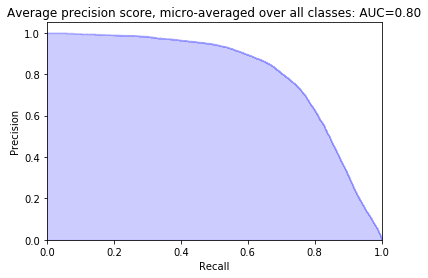

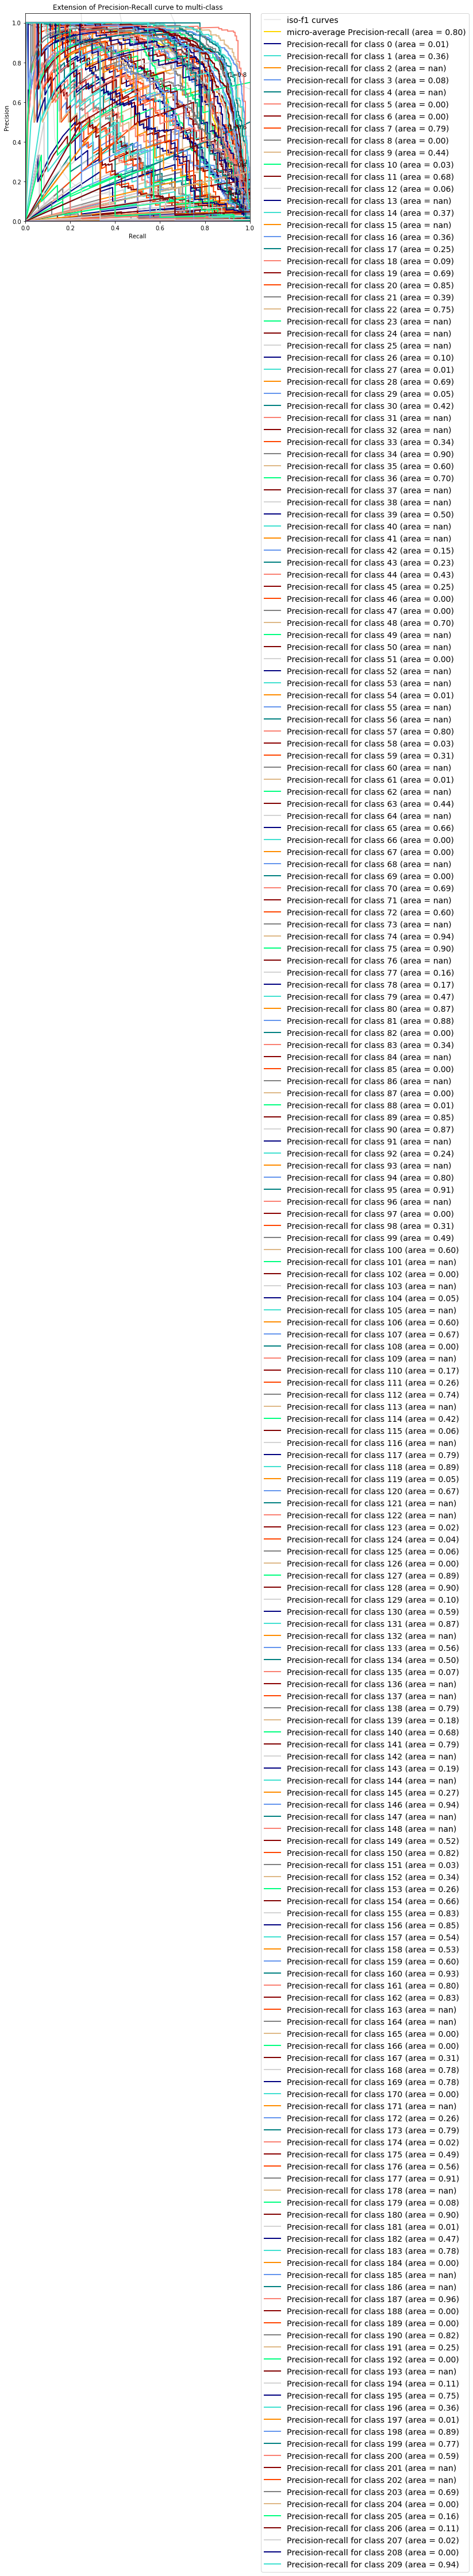

/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


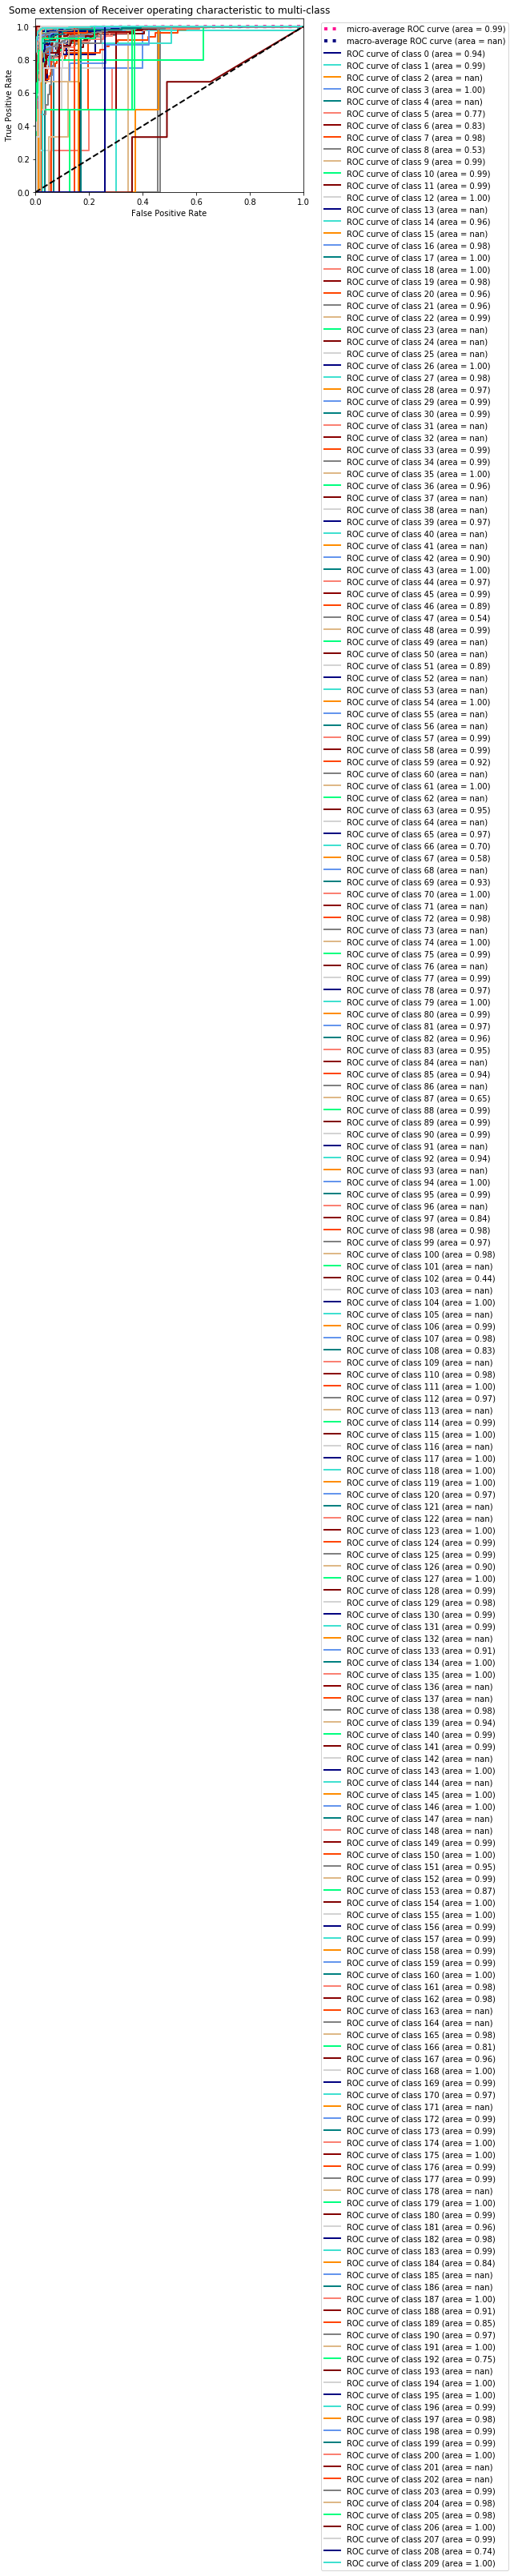

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp

y_score = model.predict(x_val)

def multilabel_metrics():
    n_classes = y_train.shape[1]
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_val[:, i],
                                                        y_score[:, i])
        average_precision[i] = average_precision_score(y_val[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_val.ravel(),
    y_score.ravel())
    average_precision["micro"] = average_precision_score(y_val, y_score,
                                                     average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))
    
    plt.figure()
    plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                 color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
    'Average precision score, micro-averaged over all classes: AUC={0:0.2f}'
    .format(average_precision["micro"]))
    plt.show()
    
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'salmon', 'darkred', 'orangered', 'grey', 'burlywood', 'springgreen', 'maroon', 'lightgrey'])

    plt.figure(figsize=(7, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

    for i, color in zip(range(n_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Extension of Precision-Recall curve to multi-class')
    plt.legend(lines, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop=dict(size=14))


    plt.show()
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
    
    lw = 2
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'salmon', 'darkred', 'orangered', 'grey', 'burlywood', 'springgreen', 'maroon', 'lightgrey'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.show()

multilabel_metrics()

Improve accuracy by training longer with some regularization mechanism (such as dropout) or by fine-tuning the Embedding layer.

We can also test how well we would have performed by not using pre-trained word embeddings, but instead initializing our Embedding layer from scratch and learning its weights during training. We just need to replace our Embedding layer with the following:

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH)
                            
After 2 epochs, this approach only gets us to 90% validation accuracy, less than what the previous model could reach in just one epoch. Our pre-trained embeddings were definitely buying us something. In general, using pre-trained embeddings is relevant for natural processing tasks were little training data is available (functionally the embeddings act as an injection of outside information which might prove useful for your model).



In [ ]:
# Build a classifier optimized for maximizing f1_score (uses class_weights)
# from keras.layers import Dropout

# clf = Sequential()

# clf.add(Dense(x_train.shape[1], 1600, activation='relu'))
# clf.add(Dropout(0.6))
# clf.add(Dense(1600, 1200, activation='relu'))
# clf.add(Dropout(0.6))
# clf.add(Dense(1200, 800, activation='relu'))
# clf.add(Dropout(0.6))
# clf.add(Dense(800, y_train.shape[1], activation='sigmoid'))

# clf.compile(optimizer=Adam(), loss='binary_crossentropy')

# clf.fit(xt, yt, batch_size=64, nb_epoch=300, validation_data=(xs, ys), class_weight=W, verbose=0)

# preds = clf.predict(xs)

# preds[preds>=0.5] = 1
# preds[preds<0.5] = 0

# print(f1_score(ys, preds, average='macro'))